In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glasspy.predict import GlassNet
from glasspy.data import SciGlass
from functools import partial
 
from funcoes import cria_populacao_compostos as cria_populacao
from funcoes import funcao_objetivo_pop as funcao_objetivo_pop
from funcoes import selecao_torneio_min as funcao_selecao
from funcoes import cruzamento_ponto_duplo as funcao_cruzamento
from funcoes import mutacao_sucessiva as funcao_mutacao_1
from funcoes import mutacao_simples as funcao_mutacao_2
from funcoes import preco_composicao

In [53]:
df_compounds_and_prices = pd.read_csv('../analise_exploratoria/Prices.csv',sep=',')

COMPOUNDS = list(df_compounds_and_prices['Oxide Coumpounds'])
PRECOS = list(df_compounds_and_prices['Price per gram(dolar/gram)'])
NUM_COMPOUNDS = len(COMPOUNDS)
VALOR_MAX_COMPOUNDS = 100

TAMANHO_POPULACAO = 30
NUM_GERACOES = 5
CHANCE_DE_CRUZAMENTO = 0.5
CHANCE_DE_MUTACAO = 0.05
CHANCE_DE_MUTACAO_POR_GENE = 0.25
TAMANHO_TORNEIO = 3

In [54]:
#source = SciGlass()
MODEL = GlassNet()

funcao_objetivo = partial(funcao_objetivo_pop, lista_de_compostos=COMPOUNDS, lista_de_precos=PRECOS, modelo=MODEL)

C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [55]:

populacao = cria_populacao(TAMANHO_POPULACAO, NUM_COMPOUNDS, VALOR_MAX_COMPOUNDS)

hall_da_fama = []

geracoes = np.arange(1,NUM_GERACOES+1,1)
melhores_das_geracoes = []
melhores_hardness = []
melhores_modulos_young = []
melhores_precos = []
composicoes_melhores = []
numeros_de_compostos_usados = []

for n in range(NUM_GERACOES):
    print(f'Geração {n}', end='\r') 
    
    # Seleção
    fitness = funcao_objetivo(populacao)        
    selecionados = funcao_selecao(populacao, fitness, TAMANHO_TORNEIO)
    
    # Cruzamento
    proxima_geracao = []
    for pai, mae in zip(selecionados[::2], selecionados[1::2]):
        individuo1, individuo2 = funcao_cruzamento(pai, mae, CHANCE_DE_CRUZAMENTO)
        proxima_geracao.append(individuo1)
        proxima_geracao.append(individuo2)
    
    # Mutação
    funcao_mutacao_1(proxima_geracao, CHANCE_DE_MUTACAO, CHANCE_DE_MUTACAO_POR_GENE, VALOR_MAX_COMPOUNDS)
    funcao_mutacao_2(proxima_geracao, CHANCE_DE_MUTACAO, VALOR_MAX_COMPOUNDS)
        
    # Atualização do hall da fama
    fitness = funcao_objetivo(proxima_geracao)
        
    menor_fitness = min(fitness)
    indice = fitness.index(menor_fitness)
    hall_da_fama.append(proxima_geracao[indice])    
        
    melhor_individuo_geracao = hall_da_fama[n]
    dict_composition = dict(zip(COMPOUNDS, melhor_individuo_geracao))
    predicao = MODEL.predict(dict_composition)
    preco_melhor_local = preco_composicao(melhor_individuo_geracao, PRECOS)


        
    dicionario_composicao_limpa = {chave: valor for chave, valor in dict_composition.items() if valor != 0}
    numero_de_compostsos = len(list(dicionario_composicao_limpa.keys()))
        
    melhores_das_geracoes.append(menor_fitness)
    melhores_hardness.append(predicao['Microhardness'].iloc[0])
    melhores_modulos_young.append(predicao['YoungModulus'].iloc[0])
    melhores_precos.append(preco_melhor_local)
    composicoes_melhores.append(dicionario_composicao_limpa)
    numeros_de_compostos_usados.append(numero_de_compostsos)
    # Encerramento
    populacao = proxima_geracao
        
fitness = funcao_objetivo(hall_da_fama)
menor_fitness = min(fitness)
indice = fitness.index(menor_fitness)
melhor_individuo_observado = hall_da_fama[indice]


Text(0, 0.5, 'Melhor Valor')

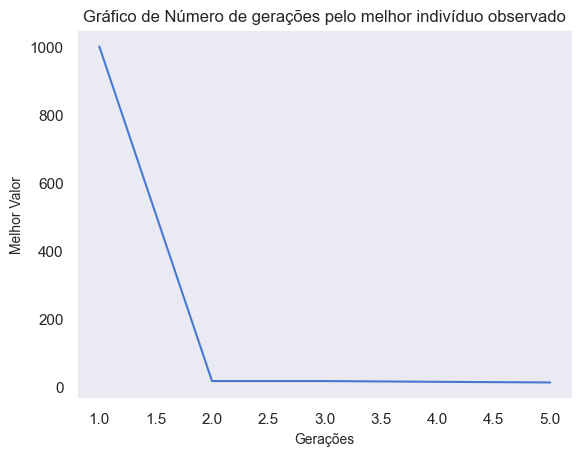

In [56]:
sns.set(style='dark', palette='muted')
plt.plot(geracoes,melhores_das_geracoes)
plt.title('Gráfico de Número de gerações pelo melhor indivíduo observado', fontsize=12)
plt.xlabel('Gerações', fontsize=10)
plt.ylabel('Melhor Valor', fontsize=10)

In [57]:
preco = preco_composicao(melhor_individuo_observado, PRECOS)

print(f"Preço: {preco}")
print(f"Módulo de Young: {float(predicao['YoungModulus'].iloc[0])}")
print(f"Microdureza: {float(predicao['Microhardness'].iloc[0])}")

Preço: 3.5575626666666667
Módulo de Young: 81.53750910062342
Microdureza: 6.367297754150751


In [58]:
evolucao = pd.DataFrame()
evolucao['Gerações'] = geracoes
evolucao['Score'] = melhores_das_geracoes
evolucao['Microhardness'] = melhores_hardness
evolucao['Módulo de Young'] = melhores_modulos_young
evolucao['Preços'] = melhores_precos
evolucao['Número de compostos usados']=numeros_de_compostos_usados
evolucao['Composição'] = composicoes_melhores
evolucao.to_excel('Melhores de cada geração.xlsx')